## **0. Intro**
In this project I will import data from OECD into the original Taylor rule from 1993, and graphically compare the results with the central bank rate for the Eurozone and USA in the period 2000-2018. After that I will estimate the coefficients of the Taylor rule with OLS and graphically compare the interest rate I get with the estimates with the central bank rates. Lastly I will look at how the estimated coefficients compare to those of the Taylor rule and comment.


## **1. Theory and choice of data**

The original Taylor rule from 1993 states:

$r=p+0.5y+0.5(p-2)+2$

Where $r$ is interest set by the central bank, $p$ is the infation rate and $y$ is the percent deviation of GDP from potential GDP. The $-2$ within the parenthesis is the inflation target of central bank(which Taylor assumed to be 2) and the $+2$ at far right is the real equilibrium interest rate(which Taylor also assumed to be 2). The inflation target still holds true today and even though the real interest rate probably isn't true today we will keep it, since it is not the focus of this project. Throughout this project I will use the term "Taylor rate" to describe the interest rate calculated by the Taylor rule. We can reduce the Taylor rule to following which we will be using when we code:

$r=1+1.5p+0.5y$

After mulitple failed attempts at gathering data from OECD's API I have chosen to download all the needed data manually into two CSV files(one for USA and one for the Eurozone) which in located in the repository together with this notebook. All data are from OECD in the period from 2000 to 2018.

Here is a list of the data used and where to download them:

 + Central bank interest rate $r$: Here I use the annual short-term interest rate as a proxy for the central bank interest rate. Found at https://stats.oecd.org/index.aspx?queryid=86. I ended up using a proxy since i coundn't find the ECB target interest rate in annual intervals. To keep it simple(and being lazy) I decided to use the same data for USA . This data i named InterestRate in the csv files.
 + Infation rate $p$: Here I use the annual consumer price index, specifically the percentage change on same period of the previous year. Found at: https://stats.oecd.org/Index.aspx?DataSetCode=PRICES_CPI. This data i named CPI in the csv files
 + Percent deviation of GDP from potential GDP $y$: Here I use OECD's annual outputgap. Found here: https://stats.oecd.org/index.aspx?QueryId=51655. This data is named OutputGap in csv files.
 + In addition to this I have added a column to the csv files called Year which contains the values 2000-2018.

## **1. Import of packages and data**
We start by importing all packages needed, then loading our csv files into pandas dataframes and displaying the dataframes to make sure the data is correct.

In [42]:
#Packages used
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm #used to do OLS regression
from statsmodels.iolib.summary2 import summary_col #Used to make a results table for our OLS regression
from IPython.display import display_html #used to display two data frames next to each other.

#Importing the data from the 2 csv files with pandas.
eurozone = pd.read_csv("Eurozone_csv.csv")
us = pd.read_csv("us_csv.csv")

#We make styler objects so we can show both dataframes next to each other.
eurozone_styler = eurozone.style.set_table_attributes("style='display:inline'").set_caption('Eurozone')
us_styler = us.style.set_table_attributes("style='display:inline'").set_caption('US')

#Displaying the styler-objects
display_html(eurozone_styler._repr_html_()+us_styler._repr_html_(), raw=True)

,Year,OutputGap,CPI,InterestRate
0,2000,1.48075,2.2,4.39177
1,2001,1.5099,2.4,4.26178
2,2002,0.646155,2.3,3.31859
3,2003,-0.317268,2.1,2.33347
4,2004,0.170508,2.2,2.10633
5,2005,0.415407,2.2,2.18467
6,2006,2.0372,2.2,3.07923
7,2007,3.38426,2.2,4.27761
8,2008,2.16703,3.3,4.63423
9,2009,-3.30778,0.3,1.22836


This looks exactly as the CSV files. We can proceed

## **2. Calculating and plotting the Taylor interest rate**
The index is changed to be the year column and its type is changed to datetime. This is done to make later plotting easier and cleaner. With datetime type we avoid numbers like 2006,5 when using years as the x-axis in plots. The Taylor rate is calculated for each year and added to the dataframe in a new column. We display the dataframes again to make sure everything is all right.

In [44]:
#We set the index of the dataframes equal to the Year column
eurozone.set_index('Year',inplace=True)
us.set_index('Year',inplace=True)

#We convert the index to a string, then convert it to a datetime variable. "%Y" means our index, which are years, are shown in full like 2000, 2001, 2002,...
eurozone.index = pd.to_datetime(eurozone.index.astype('str'), format="%Y")
us.index = pd.to_datetime(us.index.astype('str'), format="%Y")

#For both dataframes we calulate the Taylor interest rate and add it to a new column called TaylorRate
eurozone["TaylorRate"]=1.5*eurozone.CPI+0.5*eurozone.OutputGap+1
us["TaylorRate"]=(1.5*us.CPI+0.5*us.OutputGap)+1

#We make styler objects so we can show both dataframes next to each other.
eurozone_styler = eurozone.style.set_table_attributes("style='display:inline'").set_caption('Eurozone')
us_styler = us.style.set_table_attributes("style='display:inline'").set_caption('USA')

#Displaying the styler-objects
display_html(eurozone_styler._repr_html_()+us_styler._repr_html_(), raw=True)

,OutputGap,CPI,InterestRate,TaylorRate
Year,,,,
2000-01-01 00:00:00,1.48075,2.2,4.39177,5.04037
2001-01-01 00:00:00,1.5099,2.4,4.26178,5.35495
2002-01-01 00:00:00,0.646155,2.3,3.31859,4.77308
2003-01-01 00:00:00,-0.317268,2.1,2.33347,3.99137
2004-01-01 00:00:00,0.170508,2.2,2.10633,4.38525
2005-01-01 00:00:00,0.415407,2.2,2.18467,4.5077
2006-01-01 00:00:00,2.0372,2.2,3.07923,5.3186
2007-01-01 00:00:00,3.38426,2.2,4.27761,5.99213
2008-01-01 00:00:00,2.16703,3.3,4.63423,7.03352


##### **Plotting the interest rates**

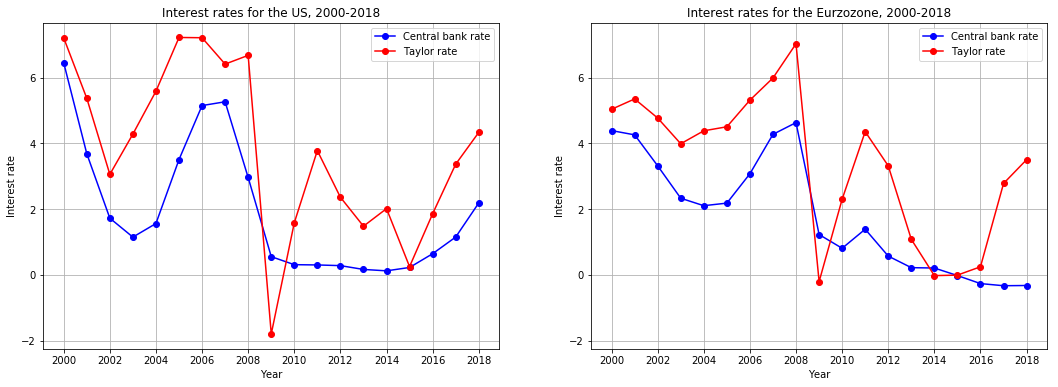

In [65]:
#We define our figure and choose white background
fig = plt.figure(num=1, figsize=(18, 6), facecolor='w') 
fig.clf()

#We make 2 subplot since we want results for USA and the Eurozone displaed next to each other
ax1=plt.subplot(1, 2, 1)
plt.title('Interest rates for the US, 2000-2018')
plt.plot(us['InterestRate'],'-bo', label="Central bank rate")
plt.plot(us['TaylorRate'],'-ro',label="Taylor rate")
plt.ylabel('Interest rate')
plt.xlabel('Year')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2, sharey=ax1)#shary is used make this subplot have same y-axis as the ax1 subplot
plt.title('Interest rates for the Eurzozone, 2000-2018')
plt.plot(eurozone['InterestRate'],'-bo',label="Central bank rate")
plt.plot(eurozone['TaylorRate'],'-ro',label="Taylor rate")
plt.ylabel('Interest rate')
plt.xlabel('Year')
plt.grid()
plt.legend()

From the plots we see that in the period 2000-2008 the Taylor rate kinda follows the central bank rate, except it is shifted upwards. From 2008 and onwards this falls apart, with the Taylor rate fluctuating a lot, while the central bank rate are more stable. This could be central banks changning behaviour due to the finansial crisis and its aftermath, which meant very low or even negative interest rates rendering traditional monetary policy tools ineffective.

## **3. Estimation of parameters and plotting of regression**

Here we estimate the paramaters of the Taylor rule with the following regression model: 

$r=\beta_01+\beta_1 y + \beta_2 p$

To do an OLS regression we have to create a dummy variable with the value of 1 for $\beta_0$ and add it our dataframes and regression. Otherwise we wont get the intercept.

In [71]:
#We add a column called "intercept" which only contains the value 1 for both dataframes.
eurozone["intercept"]=1
us["intercept"]=1

#We define our regression model. 
reg_us = sm.OLS(endog=us["InterestRate"], exog=us[["intercept","OutputGap", "CPI"]])
reg_eurozone = sm.OLS(endog=eurozone["InterestRate"], exog=eurozone[["intercept","OutputGap", "CPI"]])

#We use .fit() to estimate the coefficients of our regression models
results_us = reg_us.fit()
results_eurozone=reg_eurozone.fit()

#We define the results table using the results_* variables.
results_table = summary_col(results=[results_us,results_eurozone], #choice of models
                            float_format='%0.3f', #We want parameter in x,xxx format
                            stars = True, #We want stars to indicate p-value
                            model_names=['USA','Eurozone'], #Model names
                            regressor_order=['intercept','OutputGap','CPI'], #The shown order of parameter in table
                            info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}", 'No. observations' : lambda x: f"{int(x.nobs):d}"}) 
                            #The dictionary is used to show the R squared value and number and observations in the table.
                            
#Add title to our regression result table
results_table.add_title('Table 1 - OLS Regressions')

#Print the results table
print(results_table)

    Table 1 - OLS Regressions
                   USA    Eurozone
----------------------------------
intercept        2.061**  1.520** 
                 (0.737)  (0.714) 
OutputGap        0.661*** 0.595***
                 (0.131)  (0.148) 
CPI              0.247    0.354   
                 (0.280)  (0.348) 
R-squared        0.78     0.72    
No. observations 19       19      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


The result will be summarized and analysed at the end. To plot the interest rate we get from using the estimated coefficients, we calculate it and add it to a new column in the dataframes called OLSrate. Again we display the data frame just to make sure everything is ok.

In [69]:
#We use .predict to calculate the predicted values of the endogenous variable(the interest rate) for each year.
#The resuslt is added to a new coloumn called OLSrate
us["OLSrate"]=results_us.predict()
eurozone["OLSrate"]=results_eurozone.predict()

#We make styler objects so we can show both dataframes next to each other
eurozone_styler = eurozone.style.set_table_attributes("style='display:inline'").set_caption('Eurozone')
us_styler = us.style.set_table_attributes("style='display:inline'").set_caption('USA')

#Displaying the styler-objects
display_html(eurozone_styler._repr_html_()+us_styler._repr_html_(), raw=True)

,OutputGap,CPI,InterestRate,TaylorRate,OLSrate
Year,,,,,
2000-01-01 00:00:00,1.48075,2.2,4.39177,5.04037,3.18089
2001-01-01 00:00:00,1.5099,2.4,4.26178,5.35495,3.26909
2002-01-01 00:00:00,0.646155,2.3,3.31859,4.77308,2.71969
2003-01-01 00:00:00,-0.317268,2.1,2.33347,3.99137,2.07554
2004-01-01 00:00:00,0.170508,2.2,2.10633,4.38525,2.40122
2005-01-01 00:00:00,0.415407,2.2,2.18467,4.5077,2.54695
2006-01-01 00:00:00,2.0372,2.2,3.07923,5.3186,3.51201
2007-01-01 00:00:00,3.38426,2.2,4.27761,5.99213,4.3136
2008-01-01 00:00:00,2.16703,3.3,4.63423,7.03352,3.97895


##### **Plotting the interest rates from OLS**

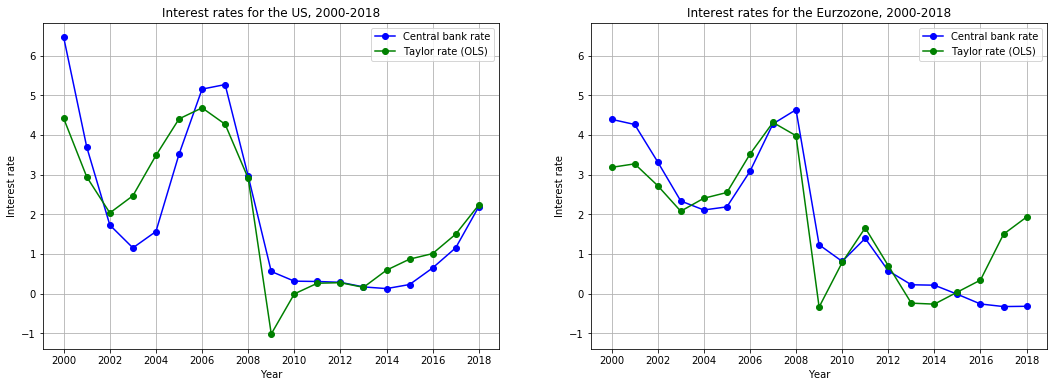

In [72]:
#We define our figure and choose white background
fig = plt.figure(num=2, figsize=(18, 6), facecolor='w')
fig.clf()

#We make 2 subplot since we want results for USA and the Eurozone displaed next to each other
ax1=plt.subplot(1, 2, 1)
plt.title('Interest rates for the US, 2000-2018')
plt.plot(us['InterestRate'],'-bo', label="Central bank rate")
plt.plot(us['OLSrate'],'-go',label="Taylor rate (OLS)")
plt.ylabel('Interest rate')
plt.xlabel('Year')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2, sharey=ax1)#shary is used make this subplot have same y-axis as the ax1 subplot
plt.title('Interest rates for the Eurzozone, 2000-2018')
plt.plot(eurozone['InterestRate'],'-bo',label="Central bank rate")
plt.plot(eurozone['OLSrate'],'-go',label="Taylor rate (OLS)")
plt.ylabel('Interest rate')
plt.xlabel('Year')
plt.grid()
plt.legend()

Our new Taylor rate fits the data far better than the original rule.

##### **Analysis of regression**

A table comparing the estimated coeficients with the coefficients of the original Taylor rule:

Model | Original Taylor rule | OLS USA | OLS Eurozone
--- | ---: | ---: | ---:
Intercept| 1 | 2.061 | 1.520
Output gap | 0.5 | 0.661 | 0.595
CPI | 1.5 | 0.247 | 0.354  

Compared to the original Taylor rule the estimated intercepts are generally larger. Under the assumption that OLS resuslt is correct, this indicates that either the real interest rate should be higher,the inflation target should be lower or the coefficient of the inflation should be lower, since the original intercept was the real interest rate minus the target inflation multiplied by 0.5. The output gap coefficients are close to identical, and the CPI coefficients  very differents. The CPI coefficients were also non-significant for both regressions as the only variable. 

This could mean that either the inflations is not as important for setting the interest rate, the model is wrong or another inflations index should be used. Another obvious error source is my choice of using the short term interest rate from OECD as a proxy for the central bank interest rate rather than the actual rate. This affects the whole regression